In [471]:
% run qpfs_class_draft.ipynb

In [472]:
% run Analysys\ Draft.ipynb

[ 1.  0.  0.  0.  1.]
{'Det Coef': 2, 'Adj Det Coef': 1, 'RSS': 0, 'BIC': 4, "Mallow's Cp": 5, 'VIF': 3}


In [473]:
class Selector():
    '''Wrapper over a selection algorithm'''
    def __init__(self, algo):
        self.algo = algo
    def fit(self, X, y):
        self.algo.fit(X, y)
    def select(self, num_features):
        return self.algo.select(num_features)

In [567]:
import matplotlib.pyplot as plt
%matplotlib inline

class ModelQuality():
    '''
    Computes the value and distribution of quality metrics for a pair (feature selection algorthm, model)
    '''
    
    def __init__(self, selector, model):
        '''
        selector - feature selection algorithm. Selector class or similar
        model - desired model
        '''
        
        self.model = model
        self.selector = selector

    def fit(self, X, y, ns_features=None, test_size=0.3, X_test=None, y_test=None):
        '''
        Fits the object to the data
        X - features
        y - answers
        
        ns_features - desired numbers of features. List of numpy array.
        If None, all numbers of features from 1 to max possible will be used.
        
        test_size - desired size of test sample in test_train_split if it is used. Default is 0.3
        
        X_test, y_test - test features and answers in case test_train_split is not used.
        If X_test is not None, test_size is ignored. Default is None.
        '''

        if X_test is None:
            from sklearn.model_selection import train_test_split
            self.X_train, self.X_test, self.y_train, self.y_test = \
                train_test_split(X, y, test_size=test_size, random_state=179)
        else:
            self.X_train = X
            self.y_train = y
            self.X_test = X_test
            self.y_test = y_test
        
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)
        self.X_test = np.array(self.X_test)
        self.y_test = np.array(self.y_test)
        
        if ns_features is None:
            self.ns_features = np.arange(self.X_train.shape[1]) + 1
            #print(ns_features)
        else:
            self.ns_features = np.sort(np.array(ns_features))
        print(self.ns_features)
        
        #create masks for all ns_features using selection algorithm
        self.masks = np.zeros((len(self.ns_features), self.X_train.shape[1]), dtype=np.bool)
        self.selector.fit(self.X_train, self.y_train)
        for (i, num) in enumerate(self.ns_features):
            cur_features = self.selector.select(num)
            self.masks[i][cur_features] = True
            
    def _calc_mean_and_std(self):
        '''Calculates the mean and std of result'''
        
        self.mean = np.mean(self.result, axis=-1)
        self.std = np.std(self.result, axis=-1)

    def evaluate(self, metrics = [], comparisons = [], characteristics = [], n_samples=20, 
                 len_sample = None, mode='static'):
        '''
        Evaluates the metric values and bootstrap distributions.
        
        metrics - desired metrics are objects of class Metric or with the same interface(see Metric)
        comparisons - desired comparisons are objects of class Comparison or with the same interface(see Comparison)
        characteristics - desired characteristics are objects of class Сharacteristic
        or with the same interface(see Characteristic)
        
        n_samples - number of bootstrap samples to generate. Default is 20.
        
        len_sample - length of each bootstrap sample
        If None, it will be equal to the number of features.
        
        mode - string. 'static' or 'dynamic'. The type of EvaluateInfo object. 
        (See StaticEvaluateInfo/DynamicEvaluateInfo)
        
        '''
        
        if mode == 'static':
            self.evaluate_info = EvaluateStaticInfo(self.model, metrics, comparisons)
        else:
            self.evaluate_info = EvaluateDynamicInfo(self.model, metrics, comparisons, characteristics)
        #print(self.evaluate_info)
        self.n_samples = n_samples
        self.len_sample = len_sample
        self.evaluate_info.fit(self.X_train, self.y_train, self.X_test, self.y_test, self.masks, n_samples, len_sample)
        self.result = self.evaluate_info.get_result()
        self.quality = self.evaluate_info.get_quality()
        self._calc_mean_and_std()
    
    def _draw_all(self, names, func):
        '''Draws graphics for several metric names'''
        
        if names is None:
            names = list(self.evaluate_info.names.keys())
        rows = (len(names)+2) // 2
        plt.figure(figsize=(20, 6 * rows))
        for i in range(len(names)):
            plt.subplot(rows, 2, i+1)
            plt.scatter(self.ns_features, np.zeros_like(self.ns_features), label='used n', alpha=0.3, color='red')
            name = names[i]
            func(name)
            plt.legend()
            plt.title(name)
            plt.xlabel('n')
        plt.show()
        
    def _get_index_by_name(self, name):
        '''Returns the index corresponding to the name of a metric'''
        return self.evaluate_info.names[name]
        
    def _draw_one(self, name):
        '''
        Draws values on test sample, mean value on bootstrap samples, std on boostrap samples and values on 
        bootstrap samples for metric with name "name"
        '''
        
        index = self._get_index_by_name(name)
        plt.plot(self.ns_features, self.quality[index], label='quality')
        plt.plot(self.ns_features, self.mean[index], label='mean')
        #plt.plot(self.ns_features, self.mean[index] + self.std[index], color='navy', label='mean+-std')
        plt.fill_between(self.ns_features, self.mean[index] - self.std[index], self.mean[index] + self.std[index],
                         alpha=0.2, label='std', color='blue')
        for i in range(self.n_samples):
            plt.plot(self.ns_features, self.result[index, :, i], color='purple', alpha=0.2)
        plt.ylabel(name)
        
    def draw(self, names=None):
        '''
        Draws values on test sample, mean value on bootstrap samples, std on boostrap samples and values on 
        bootstrap samples for metrics with names in "names"
        If names is None, graphics for all stored metrics will be drawn
        '''
        
        self._draw_all(names, self._draw_one)
    
    def _draw_std_one(self, name):
        '''
        Draws values of std computed on bootstrap samples for metric with name "name"
        '''
        
        index = self._get_index_by_name(name)
        plt.plot(self.ns_features, self.std[index], color='navy')
        plt.ylabel('std')
    
    def draw_std(self, names=None):
        '''
        Draws values of std computed on bootstrap samples for metrics with names in "names"
        If names is None, graphics for all stored metrics will be drawn
        '''
        
        self._draw_all(names, self._draw_std_one)
    
    def check_normality(self, pandas=False, criterion=None, alpha=0.05, return_original_p=False):
        '''
        Checks whether the distribution (computed with bootstrap) of values for all metrics for all numbers
        of features is normal using multiple testing (see multipletest from statsmodels).
        
        Parameters:
        pandas - whether to present the answer as pandas DataFrame. Boolean. Default is False.
        
        criterion - criterion to check normality. Function. If None, normaltest from scipy.stats will be used.
        Default is None.
        
        alpha - importance level used in the criterion. Should be a parameter of criterion. Default is 0.05.
        
        return_original_p - whether to return original p_values (not only corrected)
        
        Return value:
        (result, p, original_p) if return_original_p is True
        (result, p) if return_original_p is False
        
        result - boolean 2D numpy array or pandas DataFrame. True in a cell means that the hypothesis is rejected,
        False - that the hypothesis is not rejected.
        
        p - boolean 2D numpy array or pandas DataFrame consisting of corrected p_values.
        
        original_p - boolean 2D numpy array or pandas DataFrame consisting of original p_values.       
        '''
        
        from statsmodels.sandbox.stats.multicomp import multipletests
        if pandas:
            import pandas as pd
        if criterion is None:
            criterion = sps.normaltest
        p_val = np.zeros((len(self.result), self.result.shape[1]))
        for index in range(len(self.result)):
            for ni in range(self.result.shape[1]):
                sample = self.result[index, ni, :]
                p_val[index][ni] = criterion(sample, alpha=alpha)[1]
        res = multipletests(p_val.ravel(), method='holm')
        norm = (res[0]).reshape(p_val.shape).T
        corrected_p = (res[1]).reshape(p_val.shape).T
        p_val = p_val.T
        if pandas:
            norm = pd.DataFrame(norm, index=self.ns_features, columns=self.evaluate_info.names)
            corrected_p = pd.DataFrame(corrected_p, index=self.ns_features, 
                                            columns=self.evaluate_info.names)
            if return_original_p:
                p_val = pd.DataFrame(p_val, index=self.ns_features, columns=self.evaluate_info.names)
        if return_original_p:
            return norm, corrected_p, p_val
        else:
            return norm, corrected_p
    
    def _kullback_leibler(self, a1, s1, a2, s2):
        '''Computes the Kullback-Leibler divergence between two normal distributions'''
        if s1 == 0 or s2 == 0:
            print("Error: std=0")
            return 0
        return np.log(s2/s1) + (s1**2 + (a1 - a2)**2) / (2 * s2**2) - 1/2
    
    def _draw_KL_one(self, name):
        '''
        Draws sum for metric with name "name", where sum is an accumulated sum of KL divergence between the 
        distribution of values for n_features = i and distribution of values for n_features = i + 1 assuming that both
        distributions are normal (parameters of the distribution are replaced by their estimates).
        '''
        index = self._get_index_by_name(name)
        KL = np.zeros(len(self.ns_features))
        for i in range(1, len(self.ns_features)):
            diff = self._kullback_leibler(self.mean[index][i-1], self.std[index][i-1], 
                                          self.mean[index][i], self.std[index][i])
            KL[i] = KL[i-1] + diff
        plt.plot(self.ns_features, KL, label='accumulated KL divergence')
        plt.ylabel('KL')
        
    def draw_KL(self, names=None):
        '''
        Draws sum for metrics with names in "names", where sum is an accumulated sum of KL divergence between the 
        distribution of values for n_features = i and distribution of values for n_features = i + 1 assuming that both
        distributions are normal (parameters of the distribution are replaced by their estimates).
        '''
        self._draw_all(names, self._draw_KL_one)
        
    def summary(self, names=None):
        '''
        Prints summary for names in "names"
        '''
        if names is None:
            names = self.evaluate_info.names
        for name in names:
            index = self._get_index_by_name(name)
            cur_quality = self.quality[index]
            cur_mean = self.mean[index]
            cur_std = self.std[index]
            print(name, ":")
            print("Min metric test value:", cur_quality.min(), "with n =", cur_quality.argmin())
            print("Max metric test value:", cur_quality.max(), "with n =", cur_quality.argmax())
            print("Min metric average value", cur_mean.min(), "with n =", cur_mean.argmin())
            print("Max metric average value", cur_mean.max(), "with n =", cur_mean.argmax())
            print("Min metric std", cur_std.min(), "with n =", cur_std.argmin())
            print("Max metric std", cur_std.max(), "with n =", cur_std.argmax())
            print("Min metric mean-std", (cur_mean-cur_std).min(), "with n =", (cur_mean-cur_std).argmin())
            print("Max metric mean+std", (cur_mean+cur_std).max(), "with n =", (cur_mean+cur_std).argmax())
            print("Min metric relative std", (cur_std/cur_mean).min(), "with n =", (cur_std/cur_mean).argmin())
            print("Max metric relative std", (cur_std/cur_mean).max(), "with n =", (cur_std/cur_mean).argmax())
            print()
            
        
        
        
            

In [568]:
s = Selector(QPFS())
lin = LinearRegression()

In [569]:
q = ModelQuality(s, lin)

In [570]:
import scipy.stats as sps

XX = sps.norm.rvs(size=(100, 5))
X2 = sps.norm.rvs(size=(10, 5))
zz = sps.uniform.rvs(size=(5, 3))
yy = XX @ zz + sps.norm.rvs(scale=0.1, size=(100, 3))
y2 = X2 @ zz + sps.norm.rvs(scale=0.1, size=(10, 3))
maskk = np.ones(XX.shape[1])
maskk[2]=0
maskk[1] = 0
maskk[3] = 0
print(maskk)

metric1 = RSS()
metric2 = Adjusted_Determination_Coefficient()
metric3 = Determination_Coefficient()
metric4 = VIF()
metric5 = BIC()
char1 = Condition_Number()
comp1 = Cp()

[ 1.  0.  0.  0.  1.]


In [571]:
q.fit(XX, yy)#, ns_features = [1, 2, 4])

[1 2 3 4 5]



In [572]:
q.evaluate([metric1, metric2, metric3, metric4, metric5],
                           [comp1], [char1], mode='dynamic')

{'Det Coef': 2, 'Adj Det Coef': 1, 'Cond number': 6, 'RSS': 0, 'BIC': 4, "Mallow's Cp": 5, 'VIF': 3}


In [573]:
q.evaluate_info.names

{'Adj Det Coef': 1,
 'BIC': 4,
 'Cond number': 6,
 'Det Coef': 2,
 "Mallow's Cp": 5,
 'RSS': 0,
 'VIF': 3}

In [574]:
q.mean.shape

(7, 5)

In [575]:
q.result.shape

(7, 5, 20)

In [576]:
q.std.shape

(7, 5)

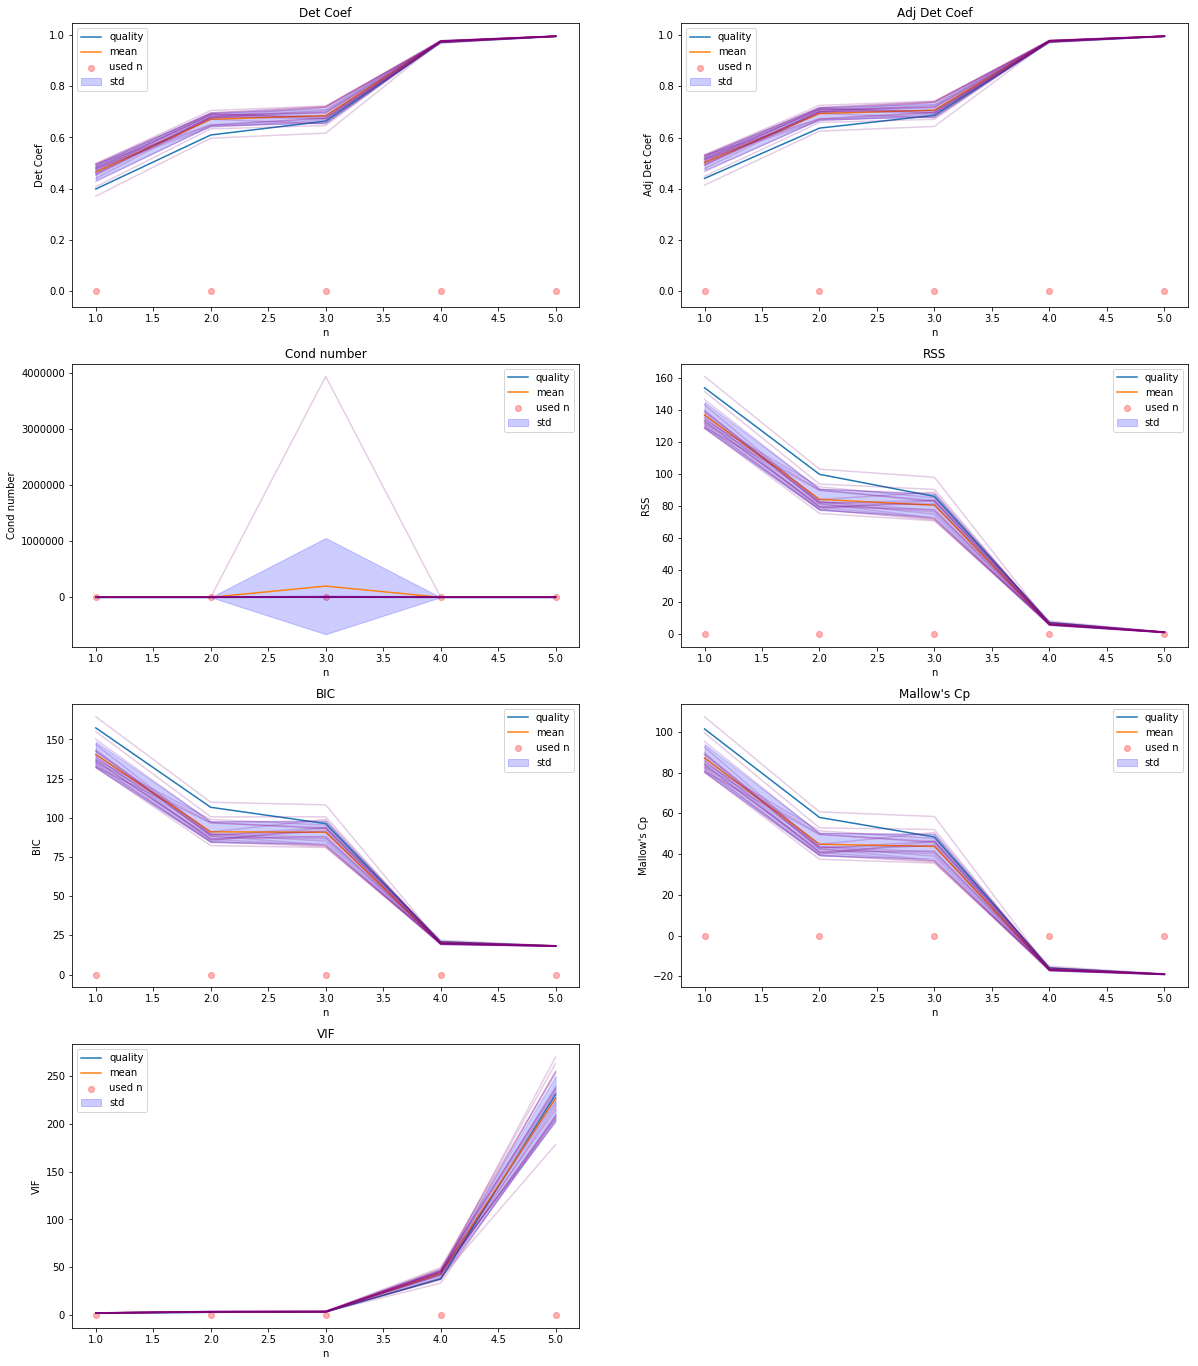

In [577]:
q.draw()

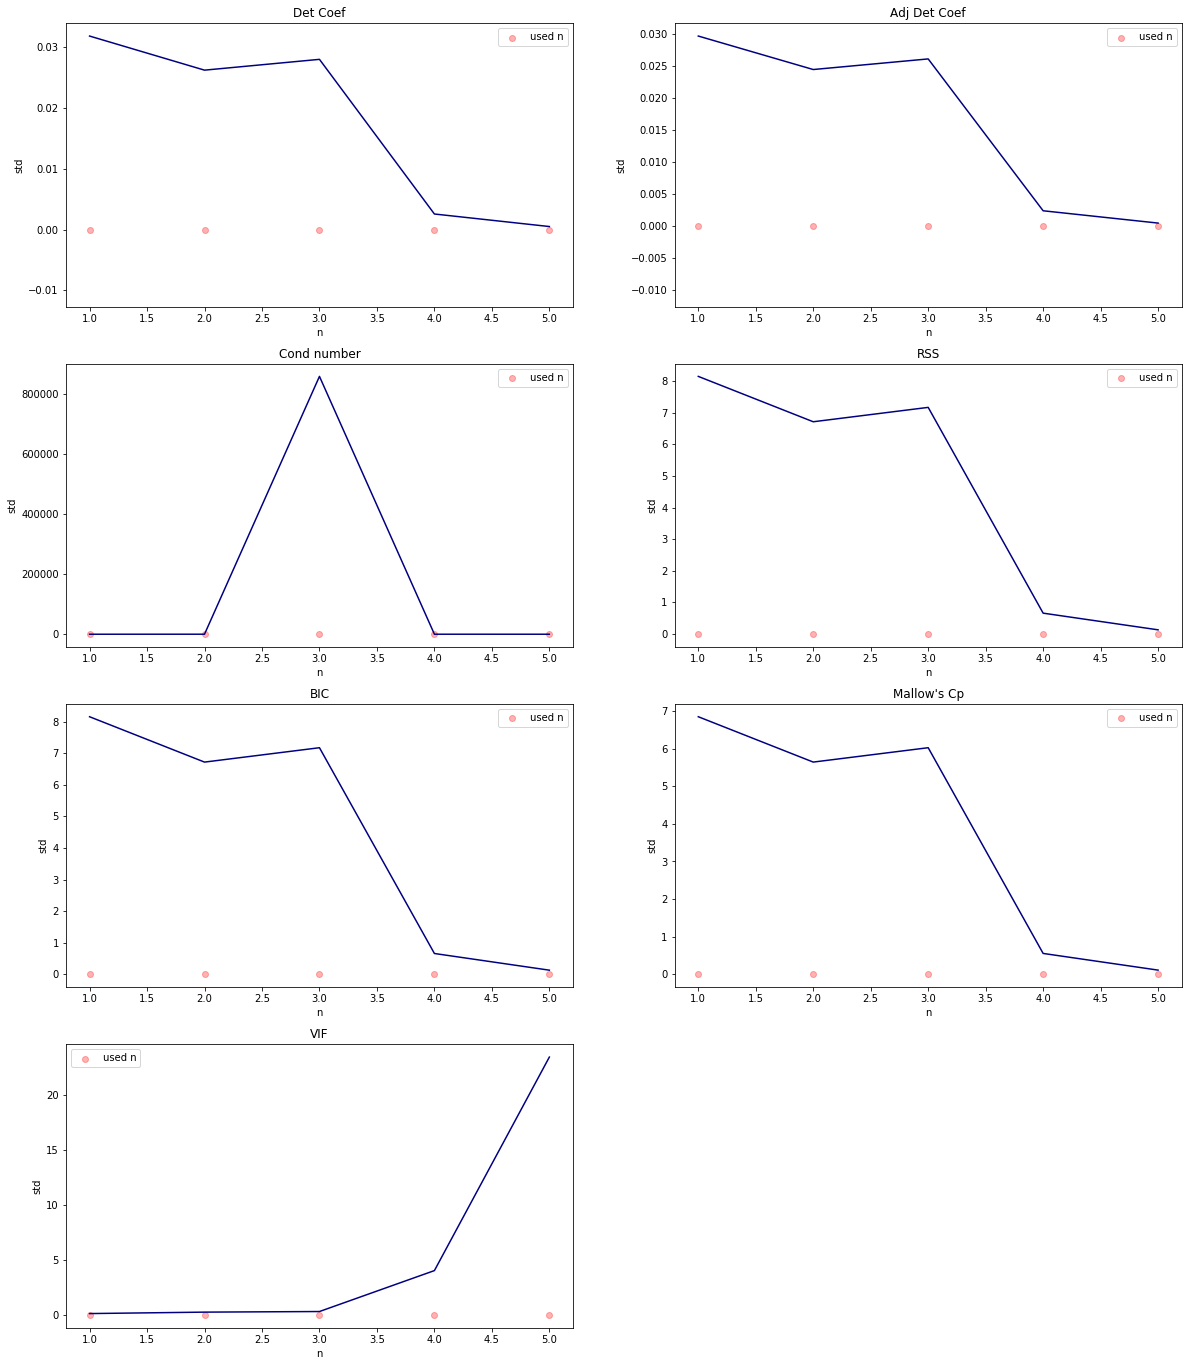

In [578]:
q.draw_std()#['Adj Det Coef','BIC', 'Det Coef', "Mallow's Cp",'RSS', 'VIF', 'Cond number'])

In [579]:
a, b, c = q.check_normality(pandas=True, return_original_p=True)

TypeError: normaltest() got an unexpected keyword argument 'alpha'

In [ ]:
a

In [ ]:
b

In [ ]:
c

Error: std=0


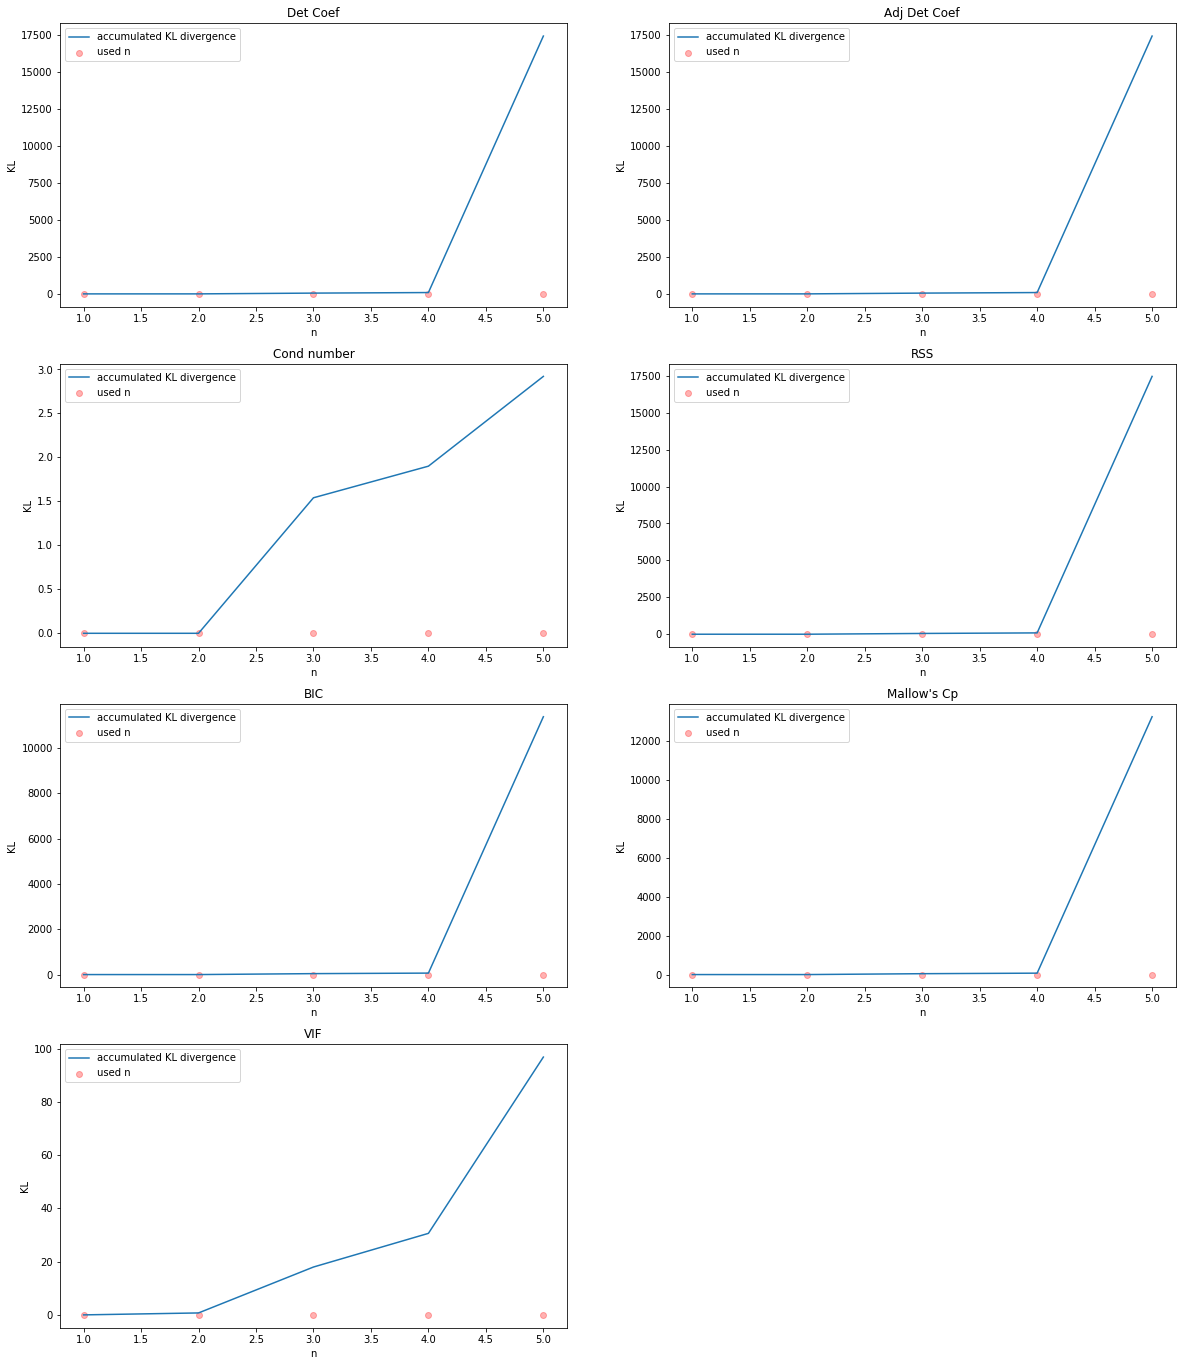

In [565]:
q.draw_KL()

In [566]:
q.summary()

Det Coef :
Min metric test value: 0.490977746667 with n = 1
Max metric test value: 0.991676987045 with n = 4
Min metric average value 0.480007015225 with n = 0
Max metric average value 0.99270084096 with n = 4
Min metric std 0.000691022857702 with n = 4
Max metric std 0.0349226280769 with n = 1
Min metric mean-std 0.445922095464 with n = 0
Max metric mean+std 0.993391863818 with n = 4
Min metric relative std 0.000696103830268 with n = 4
Max metric relative std 0.0710092117001 with n = 0

Adj Det Coef :
Min metric test value: 0.526082729656 with n = 1
Max metric test value: 0.992250987938 with n = 4
Min metric average value 0.515868600382 with n = 0
Max metric average value 0.993204231239 with n = 4
Min metric std 0.000643366108895 with n = 4
Max metric std 0.0325141709682 with n = 1
Min metric mean-std 0.484134364742 with n = 0
Max metric mean+std 0.993847597348 with n = 4
Min metric relative std 0.000647768191737 with n = 4
Max metric relative std 0.0615161217734 with n = 0

Cond numb